In [50]:
import pandas as pd
from pandas.plotting import scatter_matrix
import operator
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from collections import Counter

In [51]:
"""
    Loading dataset
    Data is verijkt met MM list
"""
df = pd.read_csv('../RAW_DATA/lld_total_labeled_dnscat.csv',encoding='utf-8')

df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [59]:
df.head(10)

,lld,label,entropy,length,numbchars,numbdots
0,0037012807fc49a441,1,3.239098,18,0.833333,0
1,00df013d4ddeacbfa0,1,3.058814,18,0.388889,0
2,00ec01280705cfa46a,1,3.302723,18,0.666667,0
3,02fd01280705cfa46a,1,3.392147,18,0.666667,0
4,051c012807fe89a44a302e300a2020202020202020696e...,1,3.457684,213,0.877934,3
5,055f013d4dde9abf81,1,3.461320,18,0.555556,0
6,0a8f013d4ddeacbfa0,1,3.266333,18,0.388889,0
7,0b62013d4dde9abf81,1,3.572431,18,0.555556,0
8,0c0401280708b9a483,1,3.149673,18,0.833333,0
9,11d001280705cfa46a,1,3.350209,18,0.722222,0


In [53]:
"""
    Build features
"""
def calcEntropy(x):
    p, lens = Counter(x), np.float(len(x))
    return -sum( count/lens * np.log2(count/lens) for count in p.values())

df['entropy'] = [calcEntropy(x) for x in df['lld']]

"""
LLD record length
"""
df['length'] = [len(x) for x in df['lld']]


"""
 Number of different characters

"""
def countChar(x):
    charsum = 0
    total = len(x)
    for char in x:
        if not char.isalpha():
            charsum = charsum + 1
    return float(charsum)/total
df['numbchars'] = [countChar(x) for x in df['lld']]

"""
Number of . in subdomain
"""
df['numbdots'] = [x.count('.') for x in df['lld']]

"""
Number of character in subdomain
"""
#df['numunique'] = [len(set(x)) for x in df['lld']]

'\nNumber of character in subdomain\n'

In [54]:
df.shape
print(df.describe().transpose())

            count       mean        std  min  25%       50%        75%  \
label      2566.0   0.073266   0.260623  0.0  0.0  0.000000   0.000000   
entropy    2566.0   2.318374   0.743679 -0.0  2.0  2.251629   2.913977   
length     2566.0  10.090023  23.464246  1.0  4.0  6.000000  10.000000   
numbchars  2566.0   0.090033   0.195403  0.0  0.0  0.000000   0.071429   
numbdots   2566.0   0.132112   0.441605  0.0  0.0  0.000000   0.000000   

                  max  
label        1.000000  
entropy      4.215355  
length     213.000000  
numbchars    1.000000  
numbdots     3.000000  


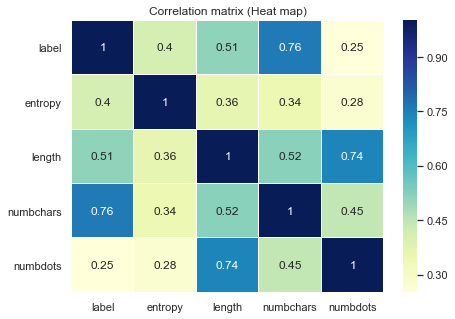

In [55]:
#correlation heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);
plt.title("Correlation matrix (Heat map)")
plt.show()

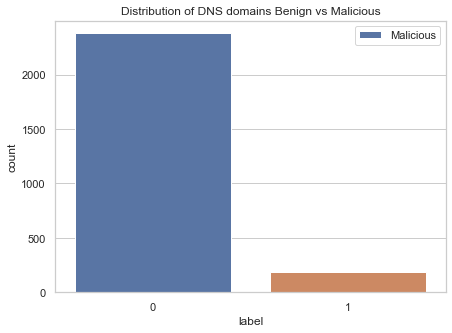

label
0    2378
1     188
dtype: int64

In [58]:
plt.figure(figsize=(7, 5))
plt.title("Distribution of DNS domains Benign vs Malicious")
sns.countplot(df.label)
plt.legend(labels=['Malicious','benign'])
plt.show()
df.groupby('label').size()

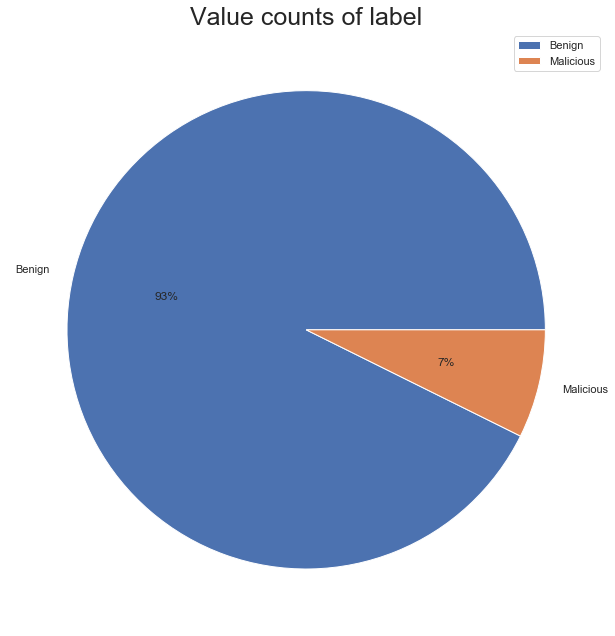

In [31]:
plt.figure(figsize=(11,11))
plt.title("Distribution of DNS domains Malicious vs Benign")
labels=df["label"].value_counts().index
sizes=df["label"].value_counts().values
plt.pie(sizes,labels=("Benign","Malicious"),autopct="%1.f%%")
plt.title("Value counts of label",size=25)
plt.legend()
plt.show()

/Users/leon/.local/share/virtualenvs/module6-_S9Ab7-7/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Pearson's r: (0.36272121226409476, 1.250034429150094e-80)


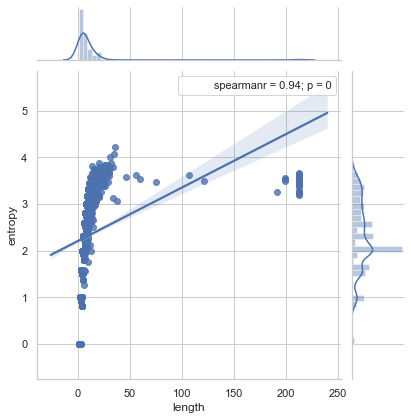

In [32]:
# correlation between 2 features
sns.set_context(rc={"figure.figsize": (7, 5)})
g = sns.JointGrid(df.length.astype(float), df.entropy.astype(float))
g.plot(sns.regplot, sns.distplot, stats.spearmanr);
print("Pearson's r: {0}".format(stats.pearsonr(df.length.astype(float), df.entropy.astype(float))))
plt.show()


/Users/leon/.local/share/virtualenvs/module6-_S9Ab7-7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


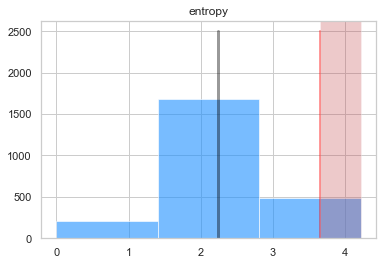

In [33]:
"""
Benign parametric upper
"""

#Regular DNS
dfBenign = df[df['label']== 0]

##DNS exfill

dfMalicious= df[df['label']== 1]

def shadedHist(df,col,bins):
    df[col].hist(bins = bins, color = 'dodgerblue', alpha = .6, normed = False)
    len_mean = df[col].mean()
    len_std = df[col].std()

    # mpl red is 3 standard deviations
    plt.plot([len_mean, len_mean], [0,2500 ],'k-',lw=3,color = 'black',alpha = .4)
    plt.plot([len_mean + (2 * len_std), len_mean + (2 * len_std)], [0, 2500], 'k-', lw=2, color = 'red', alpha = .4)
    plt.axvspan(len_mean + (2 * len_std), max(df[col]), facecolor='r', alpha=0.3)
    plt.title(col)

"""
Benign entropy distribution
"""

sns.set_context(rc={"figure.figsize": (7, 5)})
shadedHist(df[df['label']== 0],'entropy',3)
plt.show()

LinAlgError: singular matrix

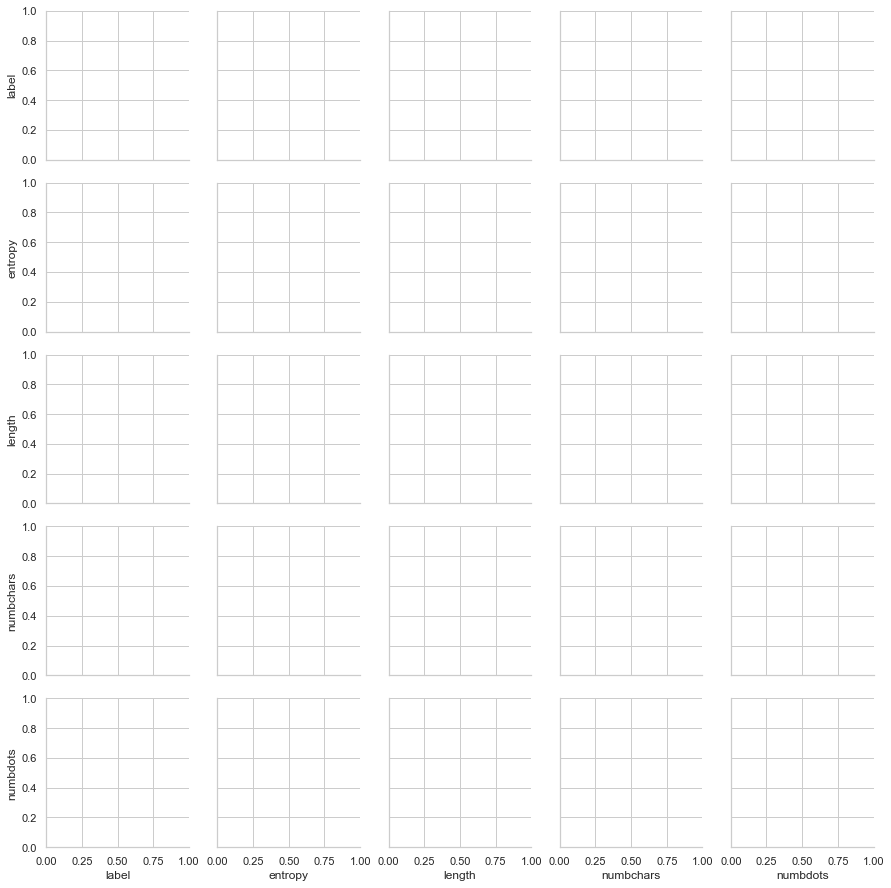

In [67]:
"""
plot pairwise relationships across an entire dataframe  between the features
"""
sns.pairplot(df,hue='label')
plt.show()

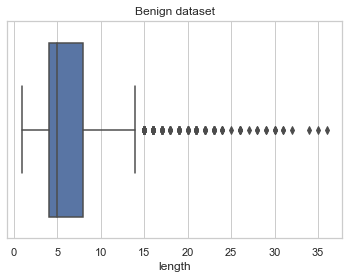

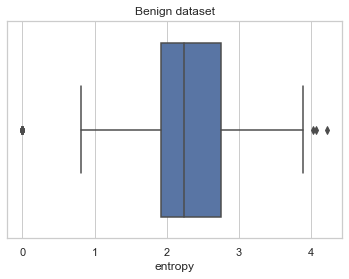

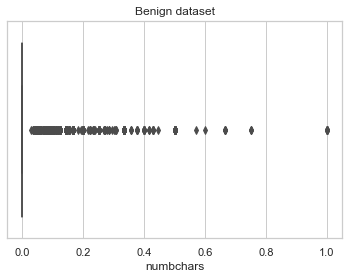

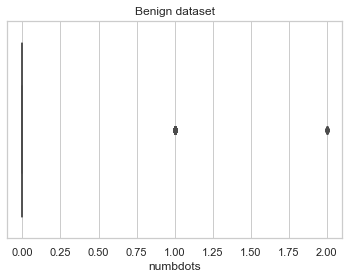

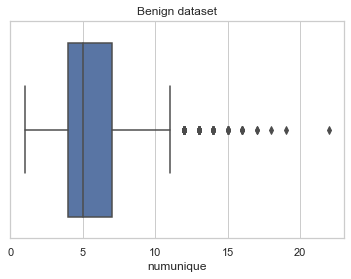

In [34]:
#Benign data
sns.set(style="whitegrid")
length = dfBenign['length']
entropy = dfBenign['entropy']
numbchars = dfBenign['numbchars']
numbdots = dfBenign['numbdots']
numunique = dfBenign['numunique']

plt.title("Benign dataset")
sns.boxplot(x=length)
plt.show()

plt.title("Benign dataset")
sns.boxplot(x=entropy)
plt.show()

plt.title("Benign dataset")
sns.boxplot(x=numbchars)
plt.show()

plt.title("Benign dataset")
sns.boxplot(x=numbdots)
plt.show()

plt.title("Benign dataset")
sns.boxplot(x=numunique)
plt.show()

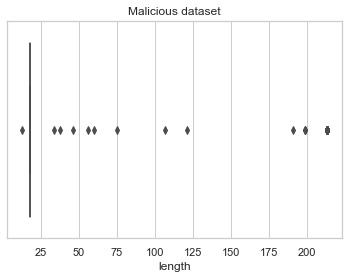

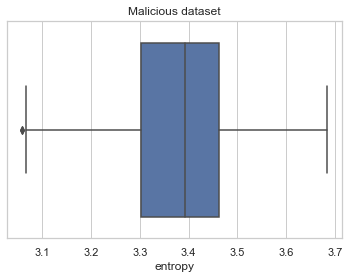

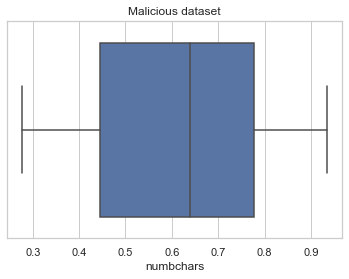

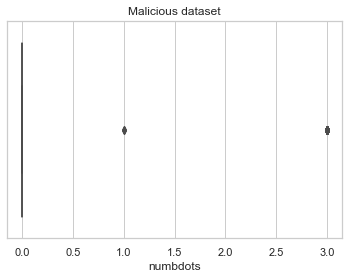

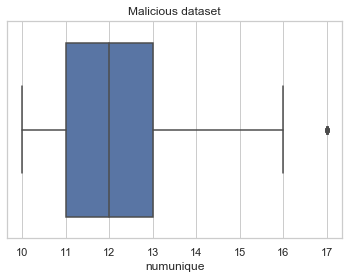

In [35]:
"""
  Box plots Malicious
"""

sns.set(style="whitegrid")
length = dfMalicious['length']
entropy = dfMalicious['entropy']
numbchars = dfMalicious['numbchars']
numbdots = dfMalicious['numbdots']
numunique = dfMalicious['numunique']

plt.title("Malicious dataset")
sns.boxplot(x=length)
plt.show()

plt.title("Malicious dataset")
sns.boxplot(x=entropy)
plt.show()

plt.title("Malicious dataset")
sns.boxplot(x=numbchars)
plt.show()

plt.title("Malicious dataset")
sns.boxplot(x=numbdots)
plt.show()

plt.title("Malicious dataset")
sns.boxplot(x=numunique)
plt.show()

In [44]:
"""
outlier with z score
"""
z = np.abs(stats.zscore(df['entropy']))
print(z)
z = np.abs(stats.zscore(df['length']))
print(z)

[1.23830788 0.99583871 1.32387875 ... 0.11088639 1.08072282 0.65764432]
[0.33717335 0.33717335 0.33717335 ... 0.13171639 0.00383737 0.13171639]


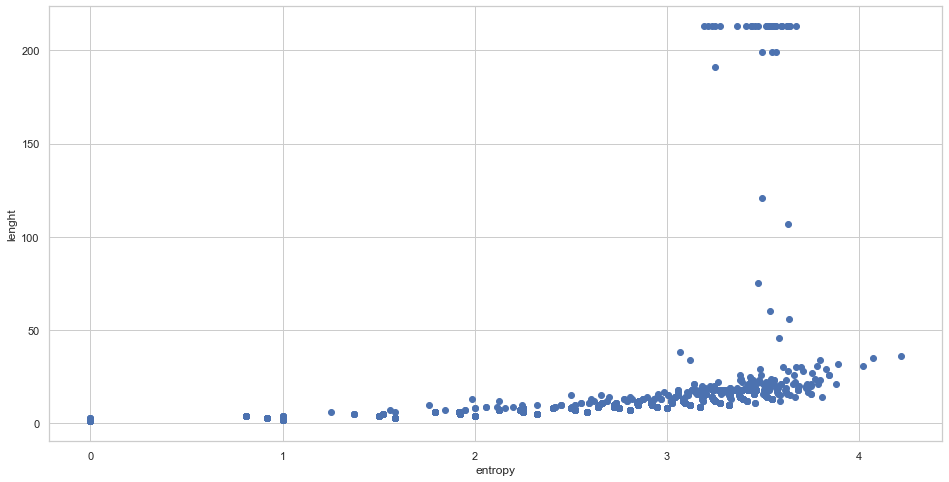

In [39]:
"""
Detecting outliers with scatter plots
"""
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['entropy'], df['length'])
ax.set_xlabel('entropy')
ax.set_ylabel('lenght')
plt.show()

In [66]:
"""
De numunique feature heeft een hoge corelatie 0.91 met entropy vandaar dat we die droppen uit de dataset
"""

df.to_csv('../lld_lab_dnscat_4features_added.csv',index=False)